In [1]:
import os
import itertools
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from time import time

import scipy
import librosa
import sed_eval

import matplotlib.pyplot as plt
import matplotlib.cm

import csv
import dcase_util

import pandas as pd

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
def FeatureExtraction(FilePath,Parameters):
    sr = Parameters['sampling_rate']
    win_size =  Parameters['win_size']
    hop_size = Parameters['hop_size']

    audio_data,audio_sr = librosa.load(FilePath,sr, mono = True)

    #Other Features might be used========================================================
    #audio_mag = np.abs(librosa.stft(audio_data, n_fft=win_size, hop_length=hop_size)) 
    #Short Time Energy
    #ste = ShortTimeEnergy(signal=audio_data,win_size=win_size,hop_size=hop_size)
        #ZCR
    #zcr = librosa.feature.zero_crossing_rate(y=audio_data,frame_length=win_size,hop_length=hop_size)
        #Spectral Centroid
    #cent = librosa.feature.spectral_centroid(y=audio_data, sr=sr,n_fft=win_size, hop_length=hop_size)
        #Spectral Entropy
    #entropy = Spectral_Entropy(y_Mag=audio_mag,sr=sr,n_short_blocks=10)
        #MFCCs and MFCCs with PCEN scaling
    #mfccs, pcens = PCEN_MFCC(y=audio_data,sr=sr,parameters=Parameters)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=20, dct_type=2, norm='ortho')
    #pnccs = PNCC(y=audio_data, sr=sr, parameters = Parameters)
    #Flatten all the feature matrix and concatenate them into a 1D vector
    #feature_vector = np.concatenate((mfccs,pnccs), axis = 0)
    return mfccs, audio_data, audio_sr
def PNCC(y,sr,parameters):
    '''
    Calculate the
        MFCCs : Mel-frequency cepstral coefficients (MFCCs)
        PCENs : using PCEN() to replace the log amplitude (dB) scaling on Mel spectra
    '''
    win_size = parameters['win_size']
    hop_size = parameters['hop_size']
    n_mels = parameters['num_mel_filters']
    n_dct = parameters['n_dct']
    fmin = parameters['min_freq']
    fmax = parameters['max_freq']
    mel_spectrogram = librosa.feature.melspectrogram(y=y, 
                                                    sr=sr,
                                                    n_fft=win_size, 
                                                    hop_length=hop_size, 
                                                    power=1, 
                                                    n_mels= n_mels,
                                                    fmin = fmin,
                                                    fmax = fmax)
    
    S_PNCC = librosa.pcen(mel_spectrogram * (2**31))
    
    return scipy.fftpack.dct(S_PNCC, axis=0, type=2, norm='ortho')[:n_dct]
def CreateLabelVector(Data,EventList,Parameters,LabelIndex=1):
    #Given audio data, event list, create its corresponding label vector with given index
    #list for saving number of frame labels. 
    hop_size = Parameters['hop_size']
    audio_sr = Parameters['sampling_rate']
    label_vector = np.zeros(int(np.ceil(len(Data)/hop_size)))                      
    for event in EventList:
        osnet_frame = np.ceil(event['onset'] * audio_sr/hop_size).astype(int)
        offset_frame = np.floor(event['offset'] * audio_sr/hop_size).astype(int)
        label_vector[osnet_frame:offset_frame] = LabelIndex
    return label_vector.astype(int)

def ComputeStateTransition(LabelVector):
        #Calculate the probability of status transition If data contains speech 
        ee_temp = 0 # num of event to event
        nn_temp = 0 # num of none to none
        en_temp = 0 # num of event to none
        ne_temp = 0 # num of none to event
        previous_e = 0 # num of frames with previous is event
        previous_n = 0 # num of frames with previous is none
        if sum(LabelVector) != 0:
            for frame_index in range(len(LabelVector)-1):
                if LabelVector[frame_index] == 0 and LabelVector[frame_index+1] > LabelVector[frame_index]:
                    previous_n = previous_n + 1
                    ne_temp = ne_temp + 1
                elif LabelVector[frame_index] == 0 and LabelVector[frame_index+1] == LabelVector[frame_index]:
                    previous_n = previous_n + 1
                    nn_temp = nn_temp + 1
                elif LabelVector[frame_index] == 1 and LabelVector[frame_index+1] < LabelVector[frame_index]:
                    previous_e = previous_e + 1
                    en_temp = en_temp + 1
                elif LabelVector[frame_index] == 1 and LabelVector[frame_index+1] == LabelVector[frame_index]:
                    previous_e = previous_e + 1
                    ee_temp = ee_temp + 1
            #compute the probability        
            p_ee = ee_temp/previous_e
            p_nn = nn_temp/previous_n
            p_en = en_temp/previous_e
            p_ne = ne_temp/previous_n
        return p_ee,p_nn,p_en,p_ne
    
def DatasetLoader(TrainPath,ValidatePath,TestPath):
    #train    
    train_data = np.load(TrainPath,allow_pickle=True)
    #validation    
    validate_data = np.load(ValidatePath,allow_pickle=True)
    #test    
    test_data = np.load(TestPath,allow_pickle=True)

    #Processing all the loaded dataset
    Train = {}
    #Train_Data = np.c_[train_data[:,0].tolist()]
    Train_Data = np.hstack(train_data[:,0].tolist()).transpose()
    Train_Label = np.hstack(train_data[:,1].tolist())
    print(Train_Data.shape)
    print(Train_Label.shape)
    #Train_Label = np.c_[train_data[:,1].tolist()]
    #Train_Data = np.hstack(Train_Data).transpose() #sklearn requires data in [n_samples,n_features]
    #Train_Label = np.hstack(Train_Label)
    Train['Data'] = Train_Data
    Train['Label'] = Train_Label

    Validation = {}
    Validate_Data = np.c_[validate_data[:,0].tolist()]
    Validate_Label = np.c_[validate_data[:,1].tolist()]
    Validate_Data = np.hstack(Validate_Data).transpose() #sklearn requires data in [n_samples,n_features]
    Validate_Label = np.hstack(Validate_Label)
    Validation['Data'] = Validate_Data
    Validation['Label'] = Validate_Label
    print(Validate_Data.shape)
    print(Validate_Label.shape)

    Test = {}
    Test_Data = np.c_[test_data[:,0].tolist()]
    Test_Label = np.c_[test_data[:,1].tolist()]
    Test_Data = np.hstack(Test_Data).transpose() #sklearn requires data in [n_samples,n_features]
    Test_Label = np.hstack(Test_Label)
    Test['Data'] = Test_Data
    Test['Label'] = Test_Label
    print(Test_Data.shape)
    print(Test_Label.shape)
    
    return Train,Validation,Test

def Write_Estimated_Annotation(Predicted_Label_Vector,AnAnnotation,AllAnnotations,Parameters):
    '''
    Predicted_Label_Vector:The predicted label vector generated by classifier
    AnAnnotation: a list for only storing a pair of onset&offset for single event
    AllAnnotaions: the list for storing multiple AnAnnotation-lists for one processing file.
    '''
    for i in range(len(Predicted_Label_Vector)-1):
                    #If next frame is different with current frame
                    if Predicted_Label_Vector[i] != Predicted_Label_Vector[i+1]:
                        #Next Frame:Speech; 
                        if Predicted_Label_Vector[i+1] - Predicted_Label_Vector[i] > 0:
                            #Append this Onset
                            AnAnnotation.append((i+1)*Parameters['hop_size']/Parameters['sampling_rate'])
                        #Next Frame:Non speech
                        elif Predicted_Label_Vector[i+1] - Predicted_Label_Vector[i] < 0:
                            #Append this Offset
                            AnAnnotation.append((i+1)*Parameters['hop_size']/Parameters['sampling_rate'])
                            AnAnnotation.append('speech')
                            if len(AnAnnotation) == 2:
                                AnAnnotation.insert(0,0)
                            AllAnnotations.append(AnAnnotation)
                            AnAnnotation = []
                    #Insert the ending frame and class label manually if the speech last til the end
                    if len(Predicted_Label_Vector) - 2 == i and Predicted_Label_Vector[i] == 1:
                        AnAnnotation.append(np.floor(len(Predicted_Label_Vector)*Parameters['hop_size']/Parameters['sampling_rate']))
                        AnAnnotation.append('speech')
                        if len(AnAnnotation) == 2:
                            AnAnnotation.insert(0,0)
                        AllAnnotations.append(AnAnnotation)
                        AnAnnotation = []
    return AllAnnotations

def Annotations_Evaluation(File_List,Annotated_Data):
    #File_List: the list of dictionaries that save all reference and estimation txt pair. see detail in doc of sed_eval
    #Annotated_Data: empty list for saving all 
    
    # Get used event labels
    all_data = dcase_util.containers.MetaDataContainer()
    #load both ref and est event lists
    for file_pair in File_List:
        reference_event_list = sed_eval.io.load_event_list(
                filename=file_pair['reference_file']
        )
        ref_speech_list = sed_eval.util.event_list.filter_event_list(reference_event_list, scene_label=None, event_label='speech', filename=None)
        
        estimated_event_list = sed_eval.io.load_event_list(
                filename=file_pair['estimated_file']
        )
        est_speech_list = sed_eval.util.event_list.filter_event_list(estimated_event_list, scene_label=None, event_label='speech', filename=None)

        Annotated_Data.append({'ref_speech_list': ref_speech_list,
                        'est_speech_list': est_speech_list})
        all_data += ref_speech_list
    # Start evaluating
    # Create metrics classes, define parameters    
    event_labels = all_data.unique_event_labels
    segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
        event_label_list=event_labels,
        time_resolution=0.1
        )
    event_based_metrics = sed_eval.sound_event.EventBasedMetrics(
    event_label_list=event_labels,
    t_collar=0.250
    )
    # Go through files
    for file_pair in Annotated_Data:
        segment_based_metrics.evaluate(
                reference_event_list=file_pair['ref_speech_list'],
                estimated_event_list=file_pair['est_speech_list']
        )

        event_based_metrics.evaluate(
                reference_event_list=file_pair['ref_speech_list'],
                estimated_event_list=file_pair['est_speech_list']
        )
    # Get only certain metrics
    overall_segment_based_metrics = segment_based_metrics.results_overall_metrics()
    print('-------------------------------------')
    print("Accuracy:", overall_segment_based_metrics['accuracy']['accuracy'])
    # print all metrics as reports
    print(segment_based_metrics)
    
def Prediction_Evaluation(Dir,Estimator,Parameters,TransitionMatrix):
    #Dir: the path of the fold that contains of the test data
    #Estimator: Pre trained testimator
    
    file_list = []#list for storing  annotated_data over all files
    annotated_data = [] #list for storing all annotation pairs

    for root, dirs,files in os.walk(Dir):
        for file in os.listdir(root):   
            if file.endswith('.txt'):
                print(file)
                # a dictionary contained ref and est pair is required by sed_eval
                ref_est_pair = {}
                AnAnnotation = [] #a list of single onset&offset pair
                AllAnnotations = []#a list for storing all onset&offset of speech events for one file
                
                #Get the processing filename without extension
                file_name = os.path.splitext(file)[0]
                
                #corresponding .wav file path
                audio_file_path = root + '/' + file_name + '.wav'                
                #This is the txt path for storing estimated annotation
                estimated_txt_path = os.getcwd() + '/estimated_txt/'  + file_name + '_estimated.txt'                
                #corresponding reference txt path
                reference_txt_path = root + '/' + file #the .txt file would be used as reference
                
                print(reference_txt_path)
                ref_est_pair['reference_file'] = reference_txt_path
                ref_est_pair['estimated_file'] = estimated_txt_path
                
                #Load Annotated Information and read speech event only                
                annotated_event = sed_eval.io.load_event_list(reference_txt_path)
                speech_event = sed_eval.util.event_list.filter_event_list(annotated_event, scene_label=None, event_label='speech', filename=None)               
                
                #process all audio data                     
                feature_vector,audio_data, audio_sr = FeatureExtraction(audio_file_path,Parameters)
                #Get Feature vector
                feature_vector = feature_vector.transpose()
                #Get true label vector
                y_label = CreateLabelVector(Data=audio_data,
                                                EventList=speech_event,
                                                Parameters=Parameters,
                                                LabelIndex=1) 
                #Predict the probability of speech for each frame
                y_pred_speech_prob = Estimator.predict_proba(feature_vector)[:,1] #[0][0] is non-speech; [0][1] is speech
                #viterbi smoothing
                viterbi_sequence = librosa.sequence.viterbi_binary(y_pred_speech_prob, TransitionMatrix, p_state=0.1, p_init=None).ravel()
                
                #create estimated annotation txt file based on predicted label vector, write all onset&offset pairs of speech events in a list
                estimated_speech_annotations = Write_Estimated_Annotation(Predicted_Label_Vector = viterbi_sequence,
                                                                          AnAnnotation = AnAnnotation,
                                                                          AllAnnotations = AllAnnotations,
                                                                          Parameters = Parameters)               
#=====================================================================   
                #write the estimated annotations
                with open(estimated_txt_path, 'w') as csv_file:
                    writer = csv.writer(csv_file, delimiter='\t')
                    writer.writerows(estimated_speech_annotations)
                file_list.append(ref_est_pair)
#=============================use sed_eval to evaluate the prediction=========  
    #file_list
    #annotated_data
    Annotations_Evaluation(File_List = file_list,
                           Annotated_Data = annotated_data)
    

In [62]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(len(params),1,sharex='none', sharey='none',figsize=(10,30))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE',fontsize = 12, va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, uplims=True, lolims=True,linestyle=':', marker="s", label='train')
        ax[i].errorbar(x, y_2, e_2, uplims=True, lolims=True,linestyle='-', marker="*",label='test' )
        ax[i].set_xlabel(p.upper())
        ax[i].legend()
        
    plt.savefig('plot.png')
    plt.show()

def sklearn_print_result(clf,test_data,test_label):
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_label, clf.predict(test_data)
    print(metrics.classification_report(y_true, y_pred))
    print()

# MFCC/Original Dataset/RandomCV

(43963, 20)
(43963,)
(9051, 20)
(9051,)
(9051, 20)
(9051,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.7s finished
/Users/anderson675/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/anderson675/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/anderson675/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBacke

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  4

Grid Searching took 0.863369099299113 mins.


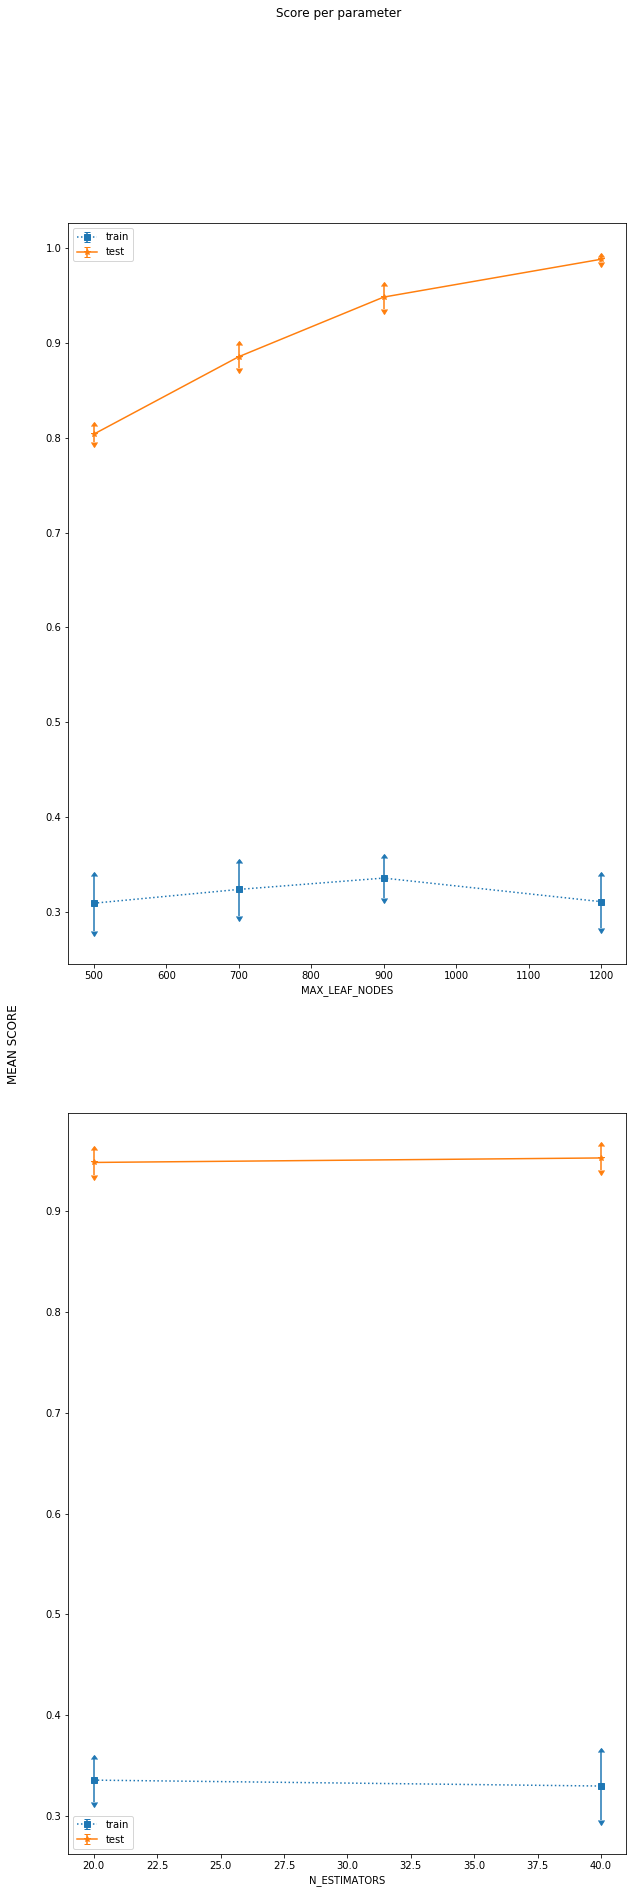

In [59]:

Params = {
    'sampling_rate':22050,
    'win_size':1024,
    'hop_size':512,
    'min_freq':80,
    'max_freq':8000,
    'num_mel_filters':128,
    'n_dct':20
}
'''
param_grid = {'n_estimators': np.arange(5,300,20),
               'max_features': ['auto','log2'],
               'max_depth': np.arange(1,60,10),
               'min_samples_split': np.arange(2,60,3),
               'min_samples_leaf': np.arange(1,60,3),
               'max_leaf_nodes':np.arange(2,60,3)}
'''
param_grid =  {'n_estimators': [ 20,40],
 #'max_depth': [ 1,  41],
 #'min_samples_split': [ 2,  42],
 #'min_samples_leaf': [ 1,  41],
 'max_leaf_nodes': [500,700,900,1200]}
#Load the dataset
example_train_path= os.getcwd()+'/JPNotebookExported/Train_MFCC_Dataset.npy'
example_validation_path = os.getcwd()+'/JPNotebookExported/Validate_MFCC_Dataset.npy'
example_test_path = os.getcwd()+'/JPNotebookExported/Test_MFCC_Dataset.npy'

#Load Transition Matrix
example_train_transition_matrix = np.load(os.getcwd()+'/JPNotebookExported/Train_MFCC_TransitionMatrix.npy',allow_pickle=True)
example_test_transition_matrix = np.load(os.getcwd()+'/JPNotebookExported/Test_MFCC_TransitionMatrix.npy',allow_pickle=True)
#Load all the data and label
example_train,example_validation,example_test = DatasetLoader(example_train_path,example_validation_path,example_test_path)
train_data,train_label = example_train['Data'], example_train['Label']
validation_data,validation_label = example_validation['Data'], example_validation['Label']
test_data,test_label = example_test['Data'], example_test['Label']

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#randomRF = RandomForestClassifier(oob_score=True,random_state=10,verbose=1, n_jobs = -1)

clf = RandomForestClassifier(oob_score=True,random_state=10,verbose=1, n_jobs = -1)
grid_search = GridSearchCV(clf,param_grid=param_grid,cv = 3,scoring = 'recall' )

start_time = time()
grid_search.fit(train_data,train_label)
print("Grid Searching took {} mins." .format((time() - start_time)/60.0))
plot_search_results(grid_search)




In [63]:
sklearn_print_result(grid_search,test_data,test_label)

Best parameters set found on development set:

{'max_leaf_nodes': 900, 'n_estimators': 20}

Grid scores on development set:

0.309 (+/-0.058) for {'max_leaf_nodes': 500, 'n_estimators': 20}
0.305 (+/-0.061) for {'max_leaf_nodes': 500, 'n_estimators': 40}
0.323 (+/-0.056) for {'max_leaf_nodes': 700, 'n_estimators': 20}
0.316 (+/-0.062) for {'max_leaf_nodes': 700, 'n_estimators': 40}
0.335 (+/-0.043) for {'max_leaf_nodes': 900, 'n_estimators': 20}
0.330 (+/-0.068) for {'max_leaf_nodes': 900, 'n_estimators': 40}
0.310 (+/-0.055) for {'max_leaf_nodes': 1200, 'n_estimators': 20}
0.318 (+/-0.068) for {'max_leaf_nodes': 1200, 'n_estimators': 40}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      8003
           1       0.51      0.27      0.35      1048

   micro avg       0.89      0.89      0.89      905

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


0.27099236641221375
0.35411471321695764
Normalized confusion matrix
[[0.96601275 0.03398725]
 [0.72900763 0.27099237]]


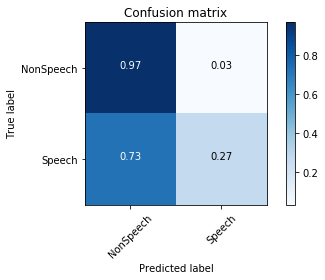

In [64]:
y_true, y_pred, y_pred_prob = test_label, grid_search.predict(test_data),grid_search.predict_proba(test_data)
print(metrics.recall_score(y_true, y_pred))
print(metrics.f1_score(y_true, y_pred))

c_metrics = metrics.confusion_matrix(y_true,y_pred)
target_names = ['NonSpeech', 'Speech']
plot_confusion_matrix(cm = c_metrics, 
                      classes = target_names,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=10, verbose=1, warm_start=False)

In [ ]:


Test_Data_path = os.getcwd()+'\TestSet'
print(Test_Data_path)
Prediction_Evaluation(Test_Data_path,best_RF,Params,example_test_transition_matrix)
pred_Test_prob = best_RF.predict_proba(test_data)[:,1]
pred_Test_class = best_RF.predict(test_data)
viterbi_result = librosa.sequence.viterbi_binary(pred_Test_prob, example_test_transition_matrix, p_state=0.1, p_init=None).ravel()
target_names = ['NonSpeech', 'Speech']
print(metrics.classification_report(test_label, viterbi_result, target_names=target_names))
c_metrics = metrics.confusion_matrix(test_label,viterbi_result)
plot_confusion_matrix(cm = c_metrics, 
                      classes = target_names,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

array([ 2, 32])

In [72]:
param_grid = {"n_estimators": np.arange(2, 250, 20),
              "max_depth": np.arange(1, 30, 5),
              "min_samples_split": np.arange(1,80,10),
              "min_samples_leaf": np.arange(1,60,10),
              "max_leaf_nodes": np.arange(2,60,10)}
param_grid

{'n_estimators': array([  2,  22,  42,  62,  82, 102, 122, 142, 162, 182, 202, 222, 242]),
 'max_depth': array([ 1,  6, 11, 16, 21, 26]),
 'min_samples_split': array([ 1, 11, 21, 31, 41, 51, 61, 71]),
 'min_samples_leaf': array([ 1, 11, 21, 31, 41, 51]),
 'max_leaf_nodes': array([ 2, 12, 22, 32, 42, 52]),
 'min_weight_fraction_leaf': array([0.1, 0.2, 0.3, 0.4])}